# Exercise 4 [Cart-Pole Model]

In [2]:
%matplotlib inline
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
from IPython.display import HTML

# Problem
We are interested in computing a linear optimal control law to stabilize the cart pole system when subjected to small
deviations from the rest position (when $x=0$, $v=0$, $\theta = \pi$ and $\omega = 0$)

<img src="cart_pole.png" alt="drawing" width="400"/>

The dynamic equations of the Cart-Pole model are written as
$$\begin{eqnarray} \dot{x} &=& v \\ 
\dot{v} &=& \frac{f + m_p \sin\theta (l \omega^2 + g \cos \theta)}{m_c + m_p \sin^2 \theta} \\
\dot{\theta} &=& \omega \\
\dot{\omega} &=& \frac{-f\cos\theta -m_p l \omega^2 \cos\theta\sin\theta - (m_c + m_p)g \sin\theta}{l(m_c + m_p \sin^2 \theta)}
\end{eqnarray}$$

which we discretize using a time step $\Delta t$
$$ \begin{eqnarray} 
x_{n+1} &=& x_n + \Delta t\cdot v_n \\ 
v_{n+1} &=& v_n + \Delta t \cdot \left( \frac{f_n + m_p \sin\theta_n (l \omega_n^2 + g \cos \theta_n)}{m_c + m_p \sin^2 \theta_n} \right)\\
\theta_{n+1} &=& \theta_n + \Delta t \cdot \omega_n \\
\omega_{n+1} &=& \omega_n + \Delta t \cdot \left( \frac{-f_n\cos\theta_n -m_p l \omega_n^2 \cos\theta_n\sin\theta_n - (m_c + m_p)g \sin\theta_n}{l(m_c + m_p \sin^2 \theta_n)}\right)
\end{eqnarray}$$

This is the equations we use to simulate the dynamics of the system below

## Simulation of the Cart-Pole model and display functions

In [3]:
def simulate_cart_pole(x0, K, uff, horizon_length, mp=1., mc=5., l=1., g=9.81):
    """
    This function integrates the cart-pole system (the nonlinear system) for horizon_length steps
    
    Arguments:
    x0: numpy vector, initial value for the system (4 numbers for x,v,theta,omega)
    K: a list of control gains (of length horizon_length)
    uff: a list of feedforward control inputs such that the control will be f[i]=K[i] * x[i] + uff[i]
    horizon_length: lenght of the horizon to integrate
    
    Returns:
    x a numpy array containing the integration result
    u a numpy array containing the control at each step
    """
    delta_t = 0.01
        
    x = np.empty([4, horizon_length+1])
    x[:,0] = x0
    
    u = np.empty([horizon_length])

    for i in range(horizon_length):
        u[i] = K[i].dot(x[:,i]) + uff[i]
        dx = np.array([x[1,i],
                      (u[i] + mp*np.sin(x[2,i])*(l*(x[3,i]**2) + g * np.cos(x[2,i])))/(mc+mp*np.sin(x[2,i])**2),
                      x[3,i],
                      (-u[i]*np.cos(x[2,i])-mp*l*(x[3,i]**2)*np.cos(x[2,i])*np.sin(x[2,i])-(mp+mc)*g*np.sin([x[2,i]]))/(l*(mc+mp*np.sin(x[2,i])**2))
                       ])
        x[:,i+1] = x[:,i] + delta_t * dx
    return x, u

In [4]:
def animate_cart_pole(x):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation
    """
    
    #subsample
    plotx = x[:,0::5]
    
#     fig = matplotlib.figure.Figure(figsize=[6,2.3])
#     matplotlib.backends.backend_agg.FigureCanvasAgg(fig)
#     ax = fig.add_subplot(111, autoscale_on=False, xlim=[-3,3], ylim=[-1.,1.3])
#     ax.grid()
    
    fig, ax = plt.subplots(figsize=(6, 2.3))
    ax.set(xlim=(-3, 3), ylim=(-1, 1.3))
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 0.5
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend = plotx[0,i] + np.sin(plotx[2,i])
        y_pend = cart_height - np.cos(plotx[2,i])
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend], [cart_height, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=50, blit=True, init_func=init)
    ani.save('./res/res.gif', writer='imagemagick') # this is working
#     plt.close(fig)
#     plt.close(ani._fig)
#     IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

## Example simulation
Example of a simulation of the cart-pole without any control input
here we set the control gains to be 0 and uff to be 0 as well

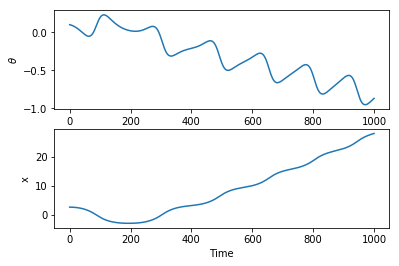

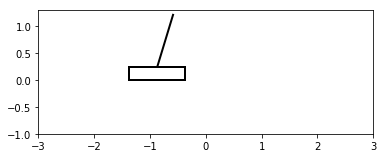

In [5]:
horizon_length = 1000 # this will simulate 10 seconds (since deltat = 0.01)

# here we set gains to 0
K = [np.array([0,0.,0,0])] * horizon_length
uff = [0.] * horizon_length

# initial conditions
x0 = np.array([0.1,-0.1,np.pi-0.5,0.])

# we simulate the system
mp=1.
mc=5.
l=1.
g=9.81
x,u = simulate_cart_pole(x0, K, uff, horizon_length, mp=1., mc=5., l=1., g=9.81)

# plot x and theta as a function of time
plt.figure()
plt.subplot(2,1,1)
plt.plot(x[0,:])
plt.ylabel(r'$\theta$')
plt.subplot(2,1,2)
plt.plot(x[2,:])
plt.ylabel('x')
plt.xlabel('Time')

# make an animation of the cart-pole
animate_cart_pole(x)

# Question 1
Linearize the discretized equations of the Cart-Pole Model around the resting position $\bar{x}=0$, $\bar{v}=0$, $\bar{\theta}=\pi$ and $\bar{\omega}=0$, $\bar{f}=0$ and write the dynamic equations in the form 

$$ \begin{bmatrix} \tilde{x}_{n+1} \\ \tilde{v}_{n+1} \\ \tilde{\theta}_{n+1} \\ \tilde{\omega}_{n+1} \end{bmatrix} = A \begin{bmatrix} \tilde{x}_{n} \\ \tilde{v}_{n} \\ \tilde{\theta}_{n} \\ \tilde{\omega}_{n} \end{bmatrix} + B \tilde{f}_n$$

where $A$ and $B$ are matrices of appropriate size and $\tilde{x}_n = x_n - \bar{x}$, $\tilde{v}_n = v_n - \bar{v}$, $\tilde{\theta}_n = \theta_n - \bar{\theta}$, $\tilde{\omega}_n = \omega_n - \bar{\omega}$ and $\tilde{f}_n = f_n - \bar{f}$. Remember that the resting position is a fixed point, i.e.

$$ \begin{bmatrix} \bar{x} \\ \bar{v} \\ \bar{\theta} \\ \bar{\omega} \end{bmatrix} = f(\bar{x}, \bar{v}, \bar{\theta}, \bar{\omega},  \bar{f})$$
where $f$ is the discretized dynamic equation of the Cart-Pole Model

# Answer for Question 1

The dynamic equations of the Cart-Pole model are written as
$$
    \dot{x} = v
$$
$$
    \dot{v} = \frac{f + m_p \sin\theta (l \omega^2 + g \cos \theta)}{m_c + m_p \sin^2 \theta}
$$
$$
    \dot{\theta} = \omega
$$
$$
    \dot{\omega} = \frac{-f\cos\theta -m_p l \omega^2 \cos\theta\sin\theta - (m_c + m_p)g \sin\theta}{l(m_c + m_p \sin^2 \theta)}
$$

Written in matrix form:
$$
    \dot{X} = F(X, U)
$$

where $X$, $U$ and $F$ here are:

$$
    X =
    \begin{bmatrix}
        x \\
        v \\
        \theta \\
        \omega
    \end{bmatrix}
    \quad
    U =
    \begin{bmatrix}
        f
    \end{bmatrix}
$$

$$
    F(X, U) =
    \begin{bmatrix}
        v \\
        \frac{f + m_p \sin\theta (l \omega^2 + g \cos \theta)}{m_c + m_p \sin^2 \theta} \$$0.6em]
        \omega \\
        \frac{-f\cos\theta -m_p l \omega^2 \cos\theta\sin\theta - (m_c + m_p)g \sin\theta}{l(m_c + m_p \sin^2 \theta)}
    \end{bmatrix}
    \triangleq
    \begin{bmatrix}
        F_1(X, U) \\
        F_2(X, U) \\
        F_3(X, U) \\
        F_4(X, U)
    \end{bmatrix}
$$

Use Taylor expansion around $ (\bar{X}, \bar{U}) $, that is $ \bar{x}=0, \bar{v}=0, \bar{\theta}=\pi, \bar{\omega}=0, \bar{f}=0 $:
$$
    F(\bar{X} + \Delta X, \bar{U} + \Delta U)
    \approx F(\bar{X}, \bar{U}) + {\Big[ \frac{\partial F}{\partial X} \Big]}_{\bar{X}, \bar{U}} \Delta X + {\Big[ \frac{\partial F}{\partial U} \Big]}_{\bar{X}, \bar{U}} \Delta U
$$

$$
    \dot{\bar{X}} + \Delta \dot{X}
    \approx F(\bar{X}, \bar{U}) + {\Big[ \frac{\partial F}{\partial X} \Big]}_{\bar{X}, \bar{U}} \Delta X + {\Big[ \frac{\partial F}{\partial U} \Big]}_{\bar{X}, \bar{U}} \Delta U
$$

$$
    \Delta \dot{X}
    \approx {\Big[ \frac{\partial F}{\partial X} \Big]}_{\bar{X}, \bar{U}} \Delta X + {\Big[ \frac{\partial F}{\partial U} \Big]}_{\bar{X}, \bar{U}} \Delta U
$$

Compute the Jacobian matrices in this equation:

$$
    \frac{\partial F}{\partial X} =
    \begin{bmatrix}
        \frac{\partial F_1}{\partial x} &
        \frac{\partial F_1}{\partial v} &
        \frac{\partial F_1}{\partial \theta} &
        \frac{\partial F_1}{\partial \omega} \\
        \frac{\partial F_2}{\partial x} &
        \frac{\partial F_2}{\partial v} &
        \frac{\partial F_2}{\partial \theta} &
        \frac{\partial F_2}{\partial \omega} \\
        \frac{\partial F_3}{\partial x} &
        \frac{\partial F_3}{\partial v} &
        \frac{\partial F_3}{\partial \theta} &
        \frac{\partial F_3}{\partial \omega} \\
        \frac{\partial F_4}{\partial x} &
        \frac{\partial F_4}{\partial v} &
        \frac{\partial F_4}{\partial \theta} &
        \frac{\partial F_4}{\partial \omega}
    \end{bmatrix}
    =
    \begin{bmatrix}
        0 & 1 & 0 & 0 \\
        0 & 0 & \frac{m_p g}{m_c} & 0 \\
        0 & 0 & 0 & 1 \\
        0 & 0 & \frac{m_c g}{(m_c + m_p) l} & 0
    \end{bmatrix}
$$

$$
    \frac{\partial F}{\partial U}
    =
    \begin{bmatrix}
        \frac{\partial F_1}{\partial f} \\
        \frac{\partial F_2}{\partial f} \\
        \frac{\partial F_3}{\partial f} \\
        \frac{\partial F_4}{\partial f}
    \end{bmatrix}
    =
    \begin{bmatrix}
        0 \\
        \frac{1}{m_c} \\
        0 \\
        \frac{1}{m_c l}
    \end{bmatrix}
$$

Then discretize the system with one-step Euler integration:
$$
    \Delta X_{n+1} =
    \Delta X_n + {\Big[ \frac{\partial F}{\partial X} \Big]}_{\bar{X}, \bar{U}} \Delta t \Delta X_n + {\Big[ \frac{\partial F}{\partial U} \Big]}_{\bar{X}, \bar{U}} \Delta t \Delta U
$$

$$
    \begin{bmatrix}
        \tilde{x}_{n+1} \\
        \tilde{v}_{n+1} \\
        \tilde{\theta}_{n+1} \\
        \tilde{\omega}_{n+1}
    \end{bmatrix}
    =
    \Bigg(
        I
        +
        \begin{bmatrix}
            0 & \Delta t & 0 & 0 \\
            0 & 0 & \frac{m_p g}{m_c} \Delta t & 0 \\
            0 & 0 & 0 & \Delta t \\
            0 & 0 & \frac{(m_c + m_p) g}{m_c l} \Delta t & 0
        \end{bmatrix}
    \Bigg)
    \begin{bmatrix}
        \tilde{x}_n \\
        \tilde{v}_n \\
        \tilde{\theta}_n \\
        \tilde{\omega}_n
    \end{bmatrix}
    +
    \begin{bmatrix}
        0 \\
        \frac{1}{m_c} \Delta t \\
        0 \\
        \frac{1}{m_c l} \Delta t
    \end{bmatrix}
    \tilde{f}_n
$$

which can be written as:
$$
    \begin{bmatrix}
        \tilde{x}_{n+1} \\
        \tilde{v}_{n+1} \\
        \tilde{\theta}_{n+1} \\
        \tilde{\omega}_{n+1}
    \end{bmatrix}
    =
    A
    \begin{bmatrix}
        \tilde{x}_{n} \\
        \tilde{v}_{n} \\
        \tilde{\theta}_{n} \\
        \tilde{\omega}_{n}
    \end{bmatrix}
    + B \tilde{f}_n
$$

where
$$
    A =
    \begin{bmatrix}
        1 & \Delta t & 0 & 0 \\
        0 & 1 & \frac{m_p g}{m_c} \Delta t & 0 \\
        0 & 0 & 1 & \Delta t \\
        0 & 0 & \frac{(m_c + m_p) g}{m_c l} \Delta t & 1
    \end{bmatrix}
    \quad
    B =
    \begin{bmatrix}
        0 \\
        \frac{1}{m_c} \Delta t \\
        0 \\
        \frac{1}{m_c l} \Delta t
    \end{bmatrix}
$$

# Question 2
We would like to use the linearized equation to compute an optimal controller that stabilizes the system around the resting position. 
1. Write a cost function that will help stabilize the resting position (be precise with the variables you use).
2. How would you (approximately) solve this optimal control problem?
3. What will be the form of the optimal controller $f_n$ (remember that the linearized system will give you $\tilde{f}_n$)?

## Answer for Question 2

### Write a cost function that will help stabilize the resting position.
Now, we can write down the cost function:
$$
    L = \tilde{X}_N^{\mathsf{T}} Q \tilde{X}_N + \sum_{k=0}^{N-1} (\tilde{X}_{n}^{\mathsf{T}} Q \tilde{X}_{n} + \tilde{U}_{n}^{\mathsf{T}} R \tilde{U}_{n})
$$

where $ Q $ and $ R $ can be customized.

And the regulator for the original nonlinear dynamic becomes:
$$
    \min_{\tilde{U_0}, \ldots, \tilde{U_{N-1}}} L(\tilde{X}, \tilde{U})
$$
$$
    s.t. \quad \tilde{X}_{n+1} = A \tilde{X}_n + B \tilde{U}_n
$$

### How would you (approximately) solve this optimal control problem?}
We can use iterative method to solve the Ricatti equation of the linearized and discretized problem, then use the solution to approximate the actual solution.

### What will be the form of the optimal controller $f_n$?
The form of the optimal controller $ f_n $ will be:
$$
    f_n = \bar{f} + K_n
    \begin{bmatrix}
        x_n - \bar{x} \\
        v_n - \bar{v} \\
        \theta_n - \bar{\theta} \\
        \omega_n - \bar{\omega}
    \end{bmatrix}
$$

# Question 3
1. Write a function (e.g. take example from Exercise 3) that computes the optimal control for the linearized problem. 2. Simulate the dynamics of the Cart-Pole Model with the computed controller for initial conditions $x=0.2$, $v=0.1$, $\theta=\pi-0.2$ and $\omega=0$. What happens? (show a plot of the states of the system and the cart-pole animation)
3. How can you change the response of the  system (how fast it stabilizes)? Give an example with a simulation.
4. Does the controller still work when $x=0.2$, $v=0.1$, $\theta=0.2$ and $\omega=0$? Why? (show a plot of the states of the system and the cart-pole animation, use a smaller horizon if necessary)

## 3.1
The dynamical system starting with initial state finally converges into the desired state $[\bar{x}, \bar{v}, \bar{\theta}, \bar{\omega}]$.

The functions and plots are shown below:

In [6]:
def solve_ricatti_equations(A, B, Q, R, horizon_length):
    """
    This function solves the backward Riccatti equations for regulator problems of the form
    min xQx + sum(xQx + uRu) subject to xn+1 = Axn + Bun
    
    Arguments:
    A, B, Q, R: numpy arrays defining the problem
    horizon_length: length of the horizon
    
    Returns:
    P: list of numpy arrays containing Pn from N to 0
    K: list of numpy arrays containing Kn from N-1 to 0
    """
    # Initialization
    P_cur = np.copy(Q)
    K_cur = None
    
    # Start iteration
    for i in range(horizon_length):
        K_cur = -linalg.pinv(R + B.transpose() @ P_cur @ B) @ (B.transpose() @ P_cur @ A)
        P_cur = Q + A.transpose() @ P_cur @ A + A.transpose() @ P_cur @ B @ K_cur
    return P_cur, K_cur


def solve_linearizate_cart_pole(Q, R, dt=0.01, mp=1., mc=5., l=1., g=9.81):
    # construct A, B
    A = np.array([
        [1., dt, 0, 0],
        [0, 1., (mp * g * dt) / mc, 0],
        [0, 0, 1, dt],
        [0, 0, ((mc + mp) * g * dt) / (mc * l) , 1]
    ])
    B = np.array([
        [0],
        [dt / mc],
        [0],
        [dt / (mc * l)]
    ])
    horizon_length = 5000
    P, K = solve_ricatti_equations(A, B, Q, R, horizon_length)
    return K

In [7]:
def evaluate_cart_pole(x0, const_K, const_uff, horizon_length=1000):
    # here we set gains to 0
    K = [const_K] * horizon_length
    uff = [const_uff] * horizon_length

    # we simulate the system
    x, u = simulate_cart_pole(x0, K, uff, horizon_length)

    # plot x and theta as a function of time
    plt.figure(figsize=(10, 12))
    plt.subplot(4, 1, 1)
    plt.plot(x[0,:])
    plt.ylabel('x')
    
    plt.subplot(4, 1, 2)
    plt.plot(x[1,:])
    plt.ylabel('v')
    
    plt.subplot(4, 1, 3)
    plt.plot(x[2,:])
    plt.ylabel(r'$\theta$')
    
    plt.subplot(4, 1, 4)
    plt.plot(x[3,:])
    plt.ylabel(r'$\omega$')
    
    plt.xlabel('Time')

    # make an animation of the cart-pole
    animate_cart_pole(x)

[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]),

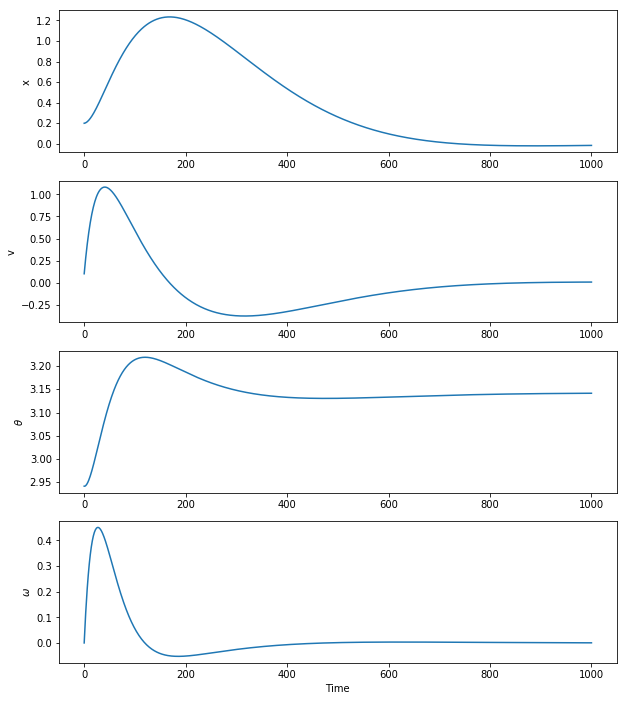

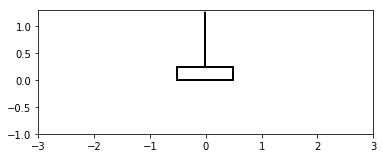

In [8]:
x0 = np.array([0.2, 0.1, np.pi - 0.2, 0])
Q = np.eye(4)
R = np.eye(1) * 0.1
const_K = solve_linearizate_cart_pole(Q, R)
const_uff = const_K @ np.array([
    [0], [0], [-np.pi], [0]
])

evaluate_cart_pole(x0, const_K, const_uff)

## 3.2
If we want to change the response of the system, we can use different $Q$ and $R$ in the cost function.

When $R$ is constant, a larger $Q$ will lead to faster convergence.

For example, if we enlarge the original $Q$ by 10 times, and use the same $R$, the result will become (which takes shorter time to converge):

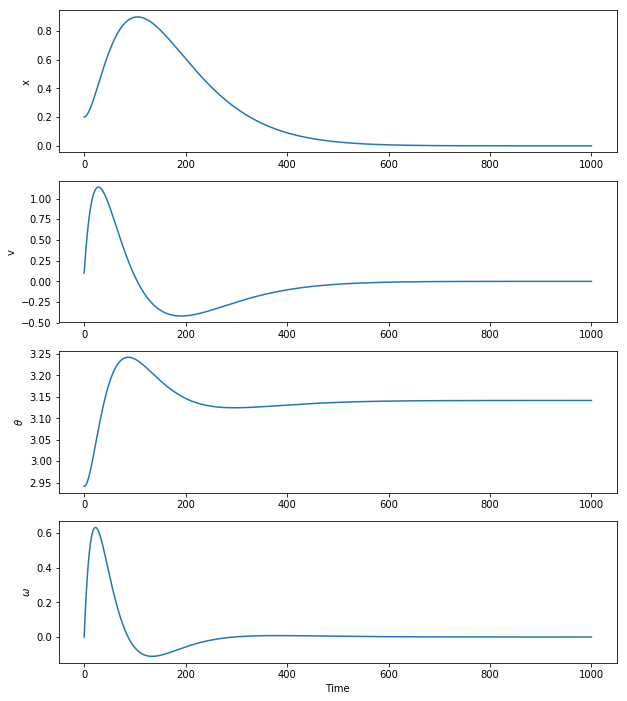

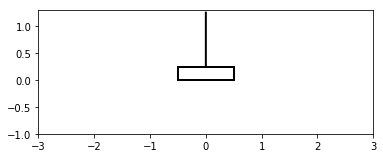

In [133]:
x0 = np.array([0.2, 0.1, np.pi - 0.2, 0])
Q = np.eye(4) * 10
R = np.eye(1) * 0.1
const_K = solve_linearizate_cart_pole(Q, R)
const_uff = const_K @ np.array([
    [0], [0], [-np.pi], [0]
])

evaluate_cart_pole(x0, const_K, const_uff)

## 3.3
In this case, our controller will not work.

Because we solve this nonlinear regulator by linearizing around the fixing point $[\bar{x}, \bar{v}, \bar{\theta}, \bar{\omega}]$, in which case, the linearized optimal controller can only be effective around a limited range of $[\bar{x}, \bar{v}, \bar{\theta}, \bar{\omega}]$. 

And now the initial $[0.2, 0.1, 0.2, 0]$ is too far away from where we have linearized the system.

And the result is shown below:

[[   3.03907214    8.52613383 -160.86331331  -48.25309766]]


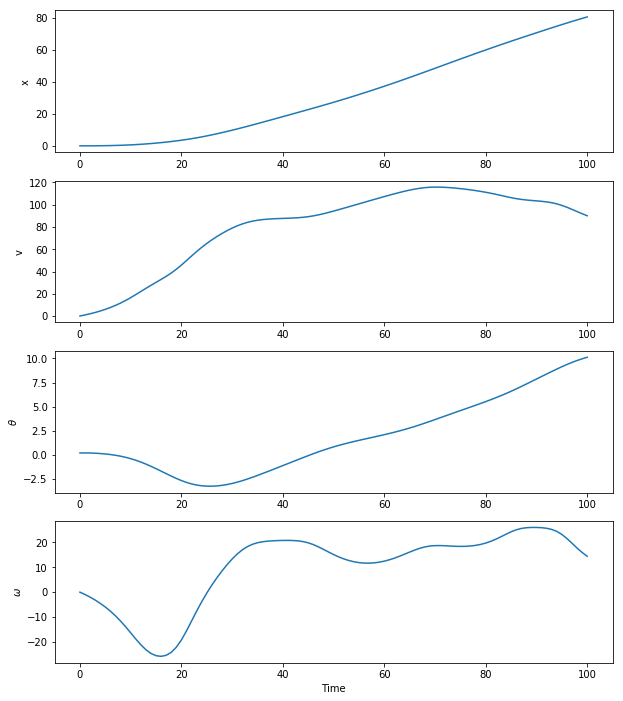

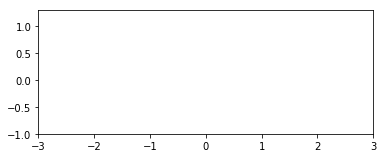

In [135]:
x0 = np.array([0.2, 0.1, 0.2, 0])
Q = np.eye(4)
R = np.eye(1) * 0.1
const_K = solve_linearizate_cart_pole(Q, R)
const_uff = const_K @ np.array([
    [0], [0], [-np.pi], [0]
])
print(K)

evaluate_cart_pole(x0, const_K, const_uff, horizon_length=100)